### Workflow
**Load data:** 
- Download 5-year period S&P500 ETF Trust data from Yahoo Finance, and import to notebook
- Check columns and missing data
  
**Feature engineering:**
- Create various features, using pair plots and correlation calculations to decide features left in the model
- Label the dependent variable as 0 and 1

**Model training and tune hyper parameters:**
- Split data to training and test sessions
- Perform feature scaling using mean and standard deviation
- Build support vector machine model and calculate indicators of prediction quality
- Tune hyper parameters using forward chaining cross-validation method and grid search
- Apply the optimal combination of hyper parameters to do prediction 

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.model_selection as skm

In [504]:
from sklearn.svm import SVC

In [506]:
roc_curve = RocCurveDisplay.from_estimator

In [508]:
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
                                    train_test_split,
                                    RandomizedSearchCV,
                                    TimeSeriesSplit,
                                    GridSearchCV,
                                    cross_val_score
                                    )

In [489]:
from sklearn.metrics import (
                            accuracy_score,
                            precision_recall_curve, 
                            roc_curve, 
                            RocCurveDisplay,
                            ConfusionMatrixDisplay,
                            classification_report, 
                            confusion_matrix
                            )

### Load Data
- Using 5-year period S&P500 ETF Trust data 

In [155]:
dfspy = pd.read_csv('spy500.csv')

In [157]:
dfspy = pd.read_csv('spy500.csv',index_col='Date')

In [159]:
dfspy

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
25-Oct-24,581.51,584.46,578.08,579.04,579.04,"47,105,000"
24-Oct-24,579.98,580.06,576.57,579.24,579.24,"34,979,900"
23-Oct-24,581.26,581.71,574.42,577.99,577.99,"49,314,600"
22-Oct-24,581.05,584.50,580.38,583.32,583.32,"34,183,800"
21-Oct-24,583.85,584.85,580.60,583.63,583.63,"36,439,000"
...,...,...,...,...,...,...
1-Nov-19,304.92,306.19,304.74,306.14,283.39,"71,141,500"
31-Oct-19,304.13,304.13,301.73,303.33,280.79,"69,053,800"
30-Oct-19,303.43,304.55,301.99,304.14,281.54,"49,643,900"


In [229]:
#dfspy.index = pd.to_datetime(dfspy.index)

In [169]:
dfspy = dfspy.sort_index(ascending=True)

In [171]:
dfspy

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-28,302.94,303.85,302.91,303.30,280.76,"42,147,000"
2019-10-29,303.00,304.23,302.86,303.21,280.68,"44,284,900"
2019-10-30,303.43,304.55,301.99,304.14,281.54,"49,643,900"
2019-10-31,304.13,304.13,301.73,303.33,280.79,"69,053,800"
2019-11-01,304.92,306.19,304.74,306.14,283.39,"71,141,500"
...,...,...,...,...,...,...
2024-10-21,583.85,584.85,580.60,583.63,583.63,"36,439,000"
2024-10-22,581.05,584.50,580.38,583.32,583.32,"34,183,800"
2024-10-23,581.26,581.71,574.42,577.99,577.99,"49,314,600"


In [173]:
print("Current column names:", dfspy.columns.tolist())

Current column names: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [175]:
dfspy.describe()

,Open,High,Low,Close,Adj Close
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,414.822663,417.331741,412.144459,414.912536,401.352186
std,71.927690,71.686598,72.041559,71.901165,76.929467
min,228.190000,229.680000,218.260000,222.950000,208.620000
25%,371.095000,374.050000,368.105000,371.180000,355.085000
50%,414.955000,416.875000,411.995000,415.220000,401.045000
75%,453.130000,454.545000,450.732500,452.470000,439.425000
max,585.910000,586.120000,582.580000,584.590000,584.590000


In [177]:
dfspy.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1258.0,414.822663,71.927690,228.19,371.095,414.955,453.1300,585.91
High,1258.0,417.331741,71.686598,229.68,374.050,416.875,454.5450,586.12
Low,1258.0,412.144459,72.041559,218.26,368.105,411.995,450.7325,582.58
Close,1258.0,414.912536,71.901165,222.95,371.180,415.220,452.4700,584.59
Adj Close,1258.0,401.352186,76.929467,208.62,355.085,401.045,439.4250,584.59


In [179]:
dfspy.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Feature Engineering
- Creating features according to the feature list below

  
  <img src='feature list.png' width=600>
  
- Labeling the dependent variable, return for the following day, as 0 or 1. The following returns more than 0.25% of previous ones are labeled as 1. Otherwise is 0.

In [285]:
def createFeatures(frame):
    df = frame.copy()
     
 
    df['OC'] = df['Adj Close'] / df['Open'] - 1
    df['HC'] = df['High'] / df['Low'] - 1
    df['RET'] = np.log(df['Adj Close'] / df['Close'].shift(1))
    df['Lagret'] = df['RET'].shift(1)


    for i in [7, 14, 28]:
        df['PCHG' + str(i)] = df['Adj Close'].pct_change(i)      
        df['MA' + str(i)] = df['Adj Close'] / df['Adj Close'].rolling(i).mean()
        alpha = 2/(i+1)
        df['EMA' + str(i)] = alpha * df['Adj Close'] + (1 - alpha) * (np.exp(df['MA' + str(i)]).shift(1))


    df['Predict'] = df['Adj Close'].shift(-1)
    df['label'] = np.where(df['Predict'] > 1.0025 *df['Adj Close'], 1, 0)

    df.dropna(inplace=True)

    return df    

In [287]:
df1 = createFeatures(dfspy)
display(df1.shape)

(1229, 21)

In [289]:
df1

,Open,High,Low,Close,Adj Close,Volume,OC,HC,RET,Lagret,...,MA7,EMA7,PCHG14,MA14,EMA14,PCHG28,MA28,EMA28,Predict,label
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-06,314.12,315.31,314.11,314.87,291.47,"48,927,000",-0.072106,0.003820,-0.068130,-0.075433,...,1.006735,74.902090,0.009875,1.008103,41.217748,0.038146,1.016176,22.653328,290.56,0
2019-12-09,314.44,315.18,313.80,313.88,290.56,"34,838,500",-0.075945,0.004398,-0.080350,-0.068130,...,1.004326,74.692489,0.005990,1.004526,41.116345,0.035200,1.011758,22.610705,290.23,0
2019-12-10,313.82,314.55,312.81,313.53,290.23,"52,649,800",-0.075170,0.005562,-0.078337,-0.080350,...,1.003542,74.605049,0.005126,1.003019,41.063865,0.030866,1.009518,22.576610,291.06,1
2019-12-11,314.03,314.70,313.44,314.42,291.06,"53,429,100",-0.073146,0.004020,-0.074366,-0.078337,...,1.005131,74.810945,0.011749,1.005049,41.170967,0.036575,1.011115,22.628121,293.57,1
2019-12-12,314.43,317.99,314.17,317.13,293.57,"96,389,600",-0.066342,0.012159,-0.068614,-0.074366,...,1.010300,75.441698,0.022144,1.012128,41.510435,0.035922,1.018548,22.805309,293.74,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-18,584.07,585.39,582.58,584.59,584.59,"37,416,800",0.000890,0.004823,0.003839,0.000086,...,1.005672,148.193679,0.018875,1.014732,80.330102,0.068505,1.024057,42.905033,583.63,0
2024-10-21,583.85,584.85,580.60,583.63,583.63,"36,439,000",-0.000377,0.007320,-0.001644,0.003839,...,1.002173,147.957808,0.026397,1.011184,80.208141,0.055923,1.020402,42.842780,583.32,0
2024-10-22,581.05,584.50,580.38,583.32,583.32,"34,183,800",0.003907,0.007099,-0.000531,-0.001644,...,1.000723,147.873147,0.025419,1.008841,80.158339,0.046539,1.018210,42.811943,577.99,0


In [198]:
dff =  df1.drop(['Open', 'High', 'Low', 'Close','Adj Close', 'Volume'], axis=1)

In [250]:
dff

,OC,HC,RET,Lagret,PCHG7,MA7,EMA7,PCHG14,MA14,EMA14,PCHG28,MA28,EMA28,Predict,label
Date,,,,,,,,,,,,,,,
2019-12-06,-0.072106,0.003820,-0.068130,-0.075433,0.002511,1.006735,74.902090,0.009875,1.008103,41.217748,0.038146,1.016176,22.653328,290.56,0
2019-12-09,-0.075945,0.004398,-0.080350,-0.068130,-0.005068,1.004326,74.692489,0.005990,1.004526,41.116345,0.035200,1.011758,22.610705,290.23,0
2019-12-10,-0.075170,0.005562,-0.078337,-0.080350,-0.002475,1.003542,74.605049,0.005126,1.003019,41.063865,0.030866,1.009518,22.576610,291.06,1
2019-12-11,-0.073146,0.004020,-0.074366,-0.078337,0.008943,1.005131,74.810945,0.011749,1.005049,41.170967,0.036575,1.011115,22.628121,293.57,1
2019-12-12,-0.066342,0.012159,-0.068614,-0.074366,0.024498,1.010300,75.441698,0.022144,1.012128,41.510435,0.035922,1.018548,22.805309,293.74,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-18,0.000890,0.004823,0.003839,0.000086,0.012908,1.005672,148.193679,0.018875,1.014732,80.330102,0.068505,1.024057,42.905033,583.63,0
2024-10-21,-0.000377,0.007320,-0.001644,0.003839,0.013018,1.002173,147.957808,0.026397,1.011184,80.208141,0.055923,1.020402,42.842780,583.32,0
2024-10-22,0.003907,0.007099,-0.000531,-0.001644,0.006453,1.000723,147.873147,0.025419,1.008841,80.158339,0.046539,1.018210,42.811943,577.99,0


### Data Visulazation and Pre-processing
- Showing pairplot and heatmap
- Getting rid of variables whose correlation > 0.9

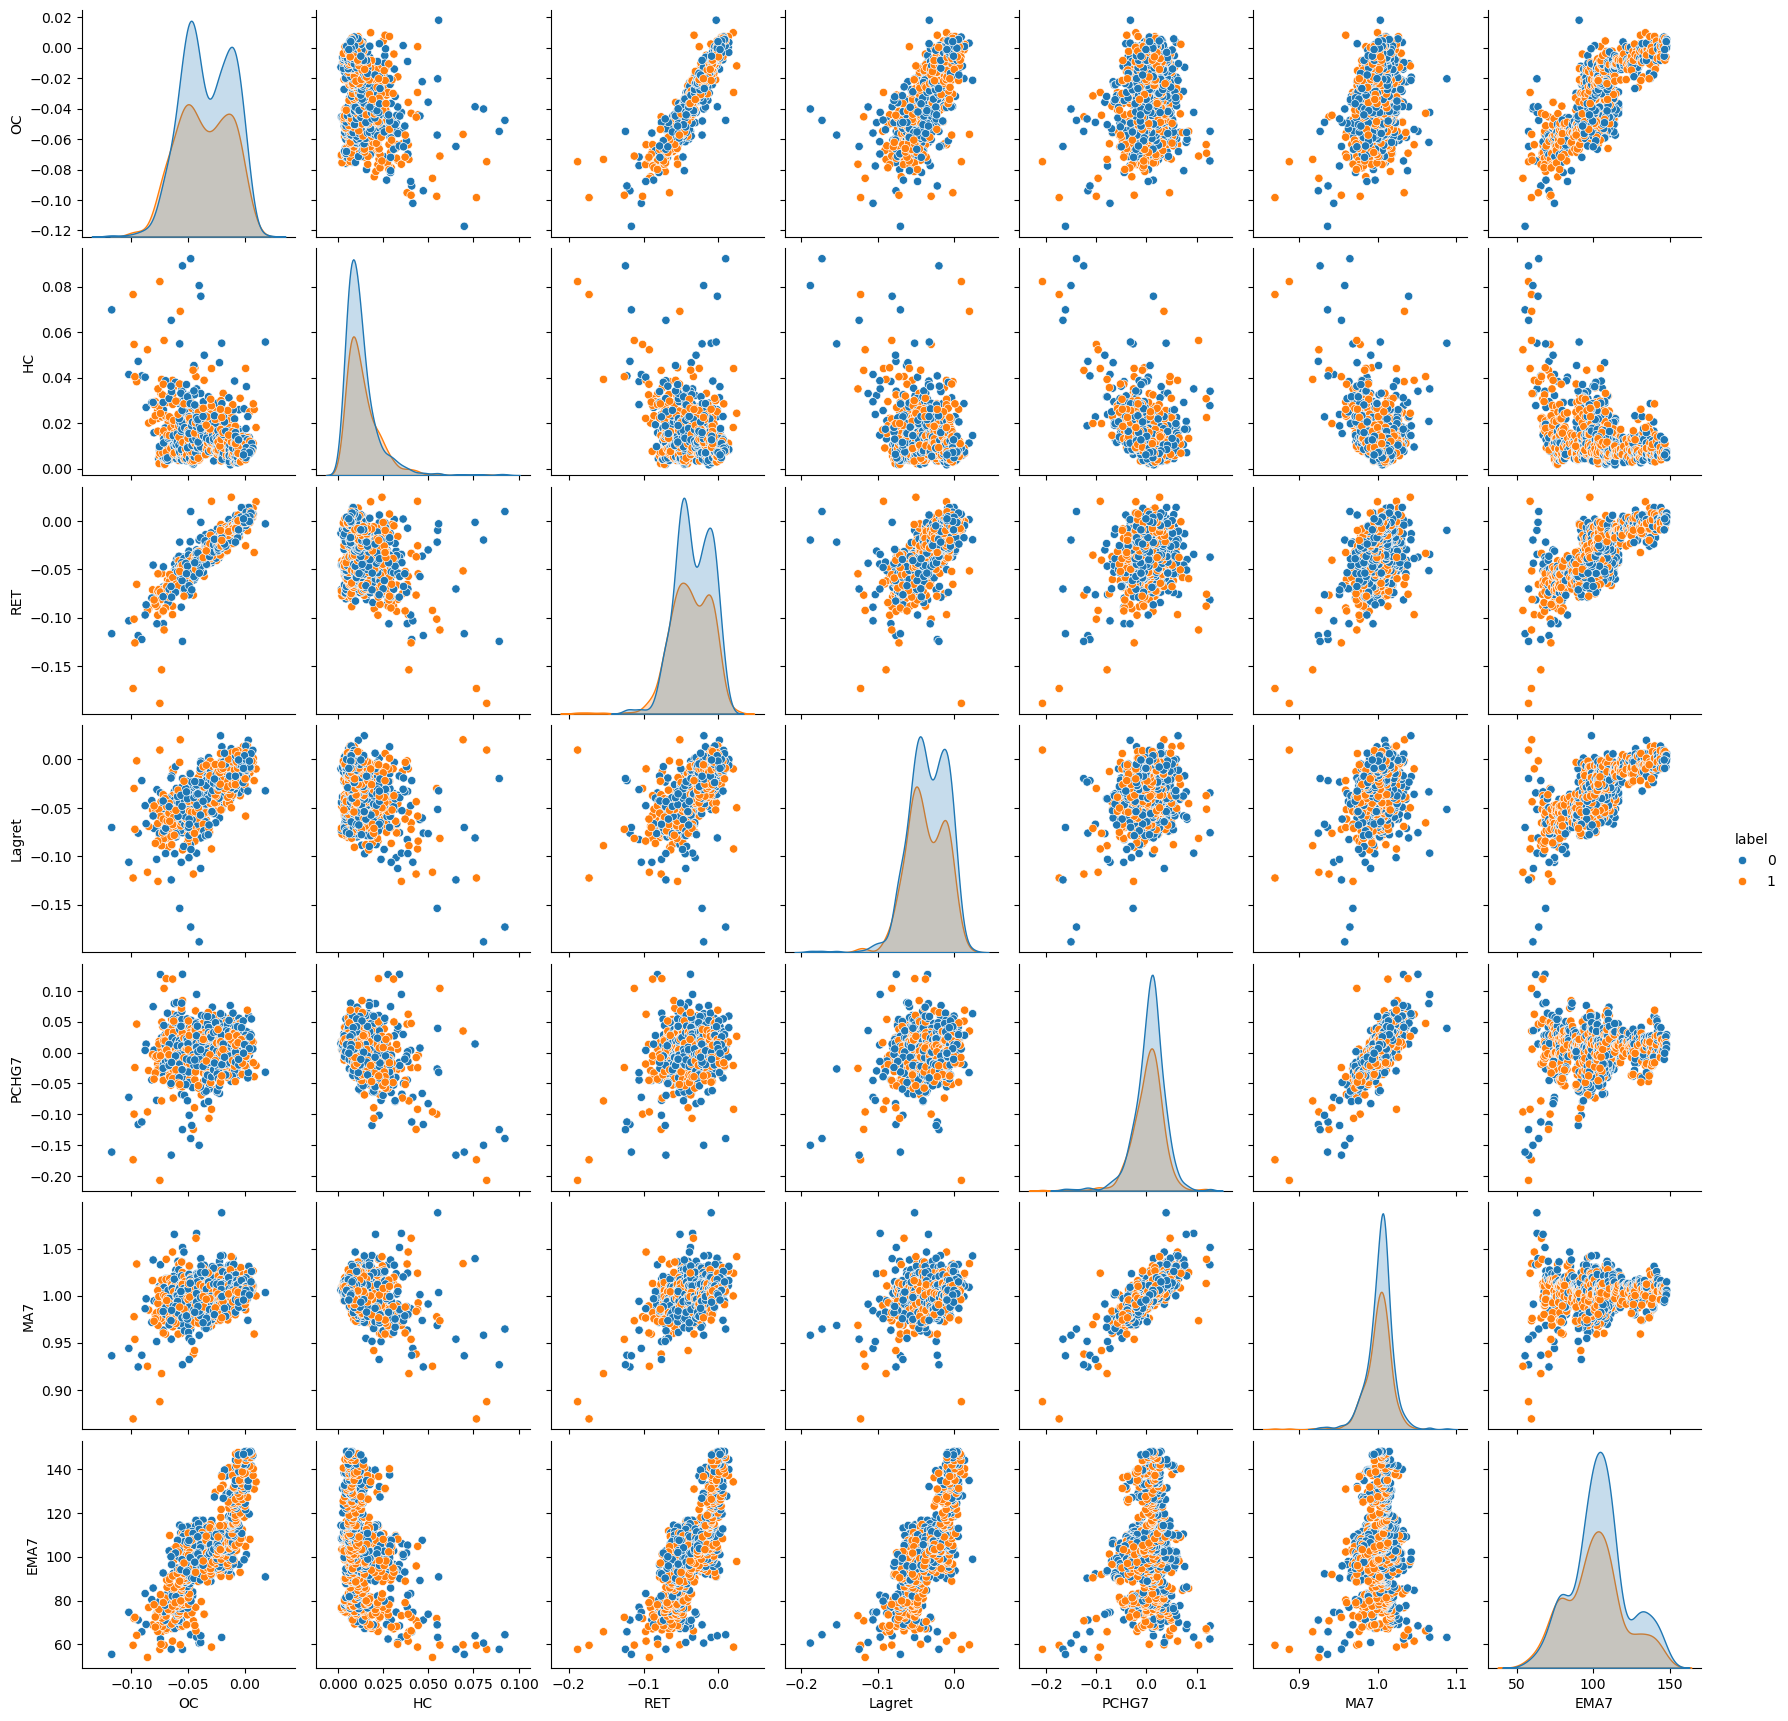

In [209]:
sns.pairplot(dff, hue = 'label', vars = ['OC', 'HC', 'RET', 'Lagret', 'PCHG7', 'MA7', 'EMA7'] )

- **Notes:** Based on the plots above, they show that some variables are not suitable to apply in the support vector machines, such as AM7 and RET.

<Axes: >

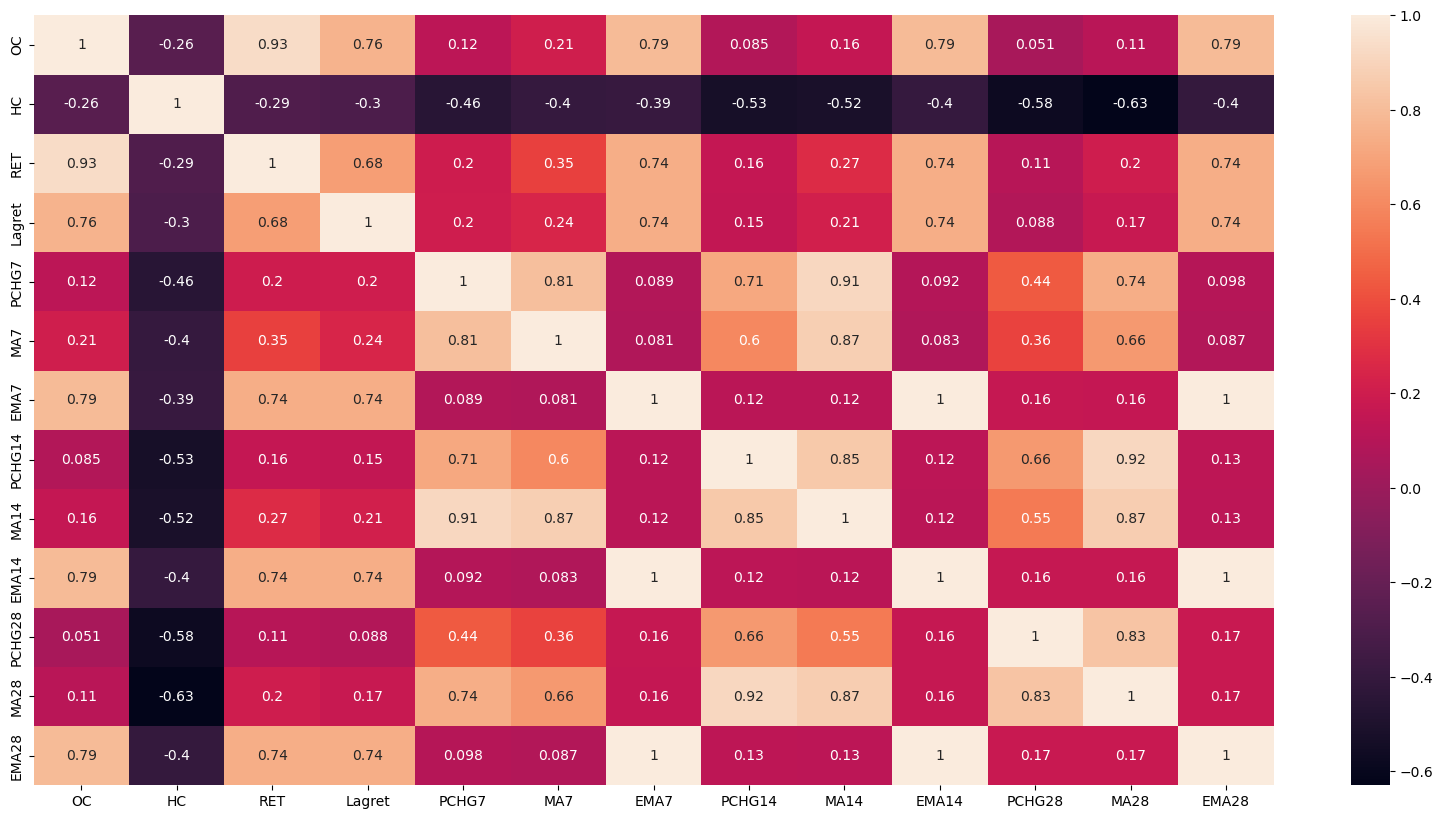

In [291]:
plt.figure(figsize=(20,10)) 
dfx =  df1.drop(['Open', 'High', 'Low', 'Close','Adj Close', 'Volume', 'Predict', 'label'], axis=1)
sns.heatmap(dfx.corr(), annot=True) 

In [224]:
def correlatedFeatures(data, threshold=0.9):
    colCorr = set()
    corrMatrix = dfx.corr()                  
    for i in range(len(corrMatrix.columns)):
            for j in range(i):
                if abs(corrMatrix.iloc[i, j]) > threshold:

                    colname = corrMatrix.columns[i]
                    colCorr.add(colname)

    return colCorr

In [226]:
correlated = correlatedFeatures(dfx, threshold=0.9)
print(correlated)

{'MA14', 'RET', 'EMA14', 'EMA28', 'MA28'}


- **Notes:** The variables listed above with correlation > 0.9 will not be in the model.

In [ ]:
dfx =  df1.drop(correlated, axis=1,inplace=True)

In [261]:
#featureNames = dfx.columns

In [264]:
dfx

,OC,HC,Lagret,PCHG7,MA7,EMA7,PCHG14,PCHG28
Date,,,,,,,,
2019-12-06,-0.072106,0.003820,-0.075433,0.002511,1.006735,74.902090,0.009875,0.038146
2019-12-09,-0.075945,0.004398,-0.068130,-0.005068,1.004326,74.692489,0.005990,0.035200
2019-12-10,-0.075170,0.005562,-0.080350,-0.002475,1.003542,74.605049,0.005126,0.030866
2019-12-11,-0.073146,0.004020,-0.078337,0.008943,1.005131,74.810945,0.011749,0.036575
2019-12-12,-0.066342,0.012159,-0.074366,0.024498,1.010300,75.441698,0.022144,0.035922
...,...,...,...,...,...,...,...,...
2024-10-18,0.000890,0.004823,0.000086,0.012908,1.005672,148.193679,0.018875,0.068505
2024-10-21,-0.000377,0.007320,0.003839,0.013018,1.002173,147.957808,0.026397,0.055923
2024-10-22,0.003907,0.007099,-0.001644,0.006453,1.000723,147.873147,0.025419,0.046539


- **Notes:** Finally, there are 8 independent variables left: OC, HC, Lagret, PCHG7, MA7, EMA7, PCHG14 and PCHG28.

In [299]:
X = dfx

In [301]:
X

,OC,HC,Lagret,PCHG7,MA7,EMA7,PCHG14,PCHG28
Date,,,,,,,,
2019-12-06,-0.072106,0.003820,-0.075433,0.002511,1.006735,74.902090,0.009875,0.038146
2019-12-09,-0.075945,0.004398,-0.068130,-0.005068,1.004326,74.692489,0.005990,0.035200
2019-12-10,-0.075170,0.005562,-0.080350,-0.002475,1.003542,74.605049,0.005126,0.030866
2019-12-11,-0.073146,0.004020,-0.078337,0.008943,1.005131,74.810945,0.011749,0.036575
2019-12-12,-0.066342,0.012159,-0.074366,0.024498,1.010300,75.441698,0.022144,0.035922
...,...,...,...,...,...,...,...,...
2024-10-18,0.000890,0.004823,0.000086,0.012908,1.005672,148.193679,0.018875,0.068505
2024-10-21,-0.000377,0.007320,0.003839,0.013018,1.002173,147.957808,0.026397,0.055923
2024-10-22,0.003907,0.007099,-0.001644,0.006453,1.000723,147.873147,0.025419,0.046539


In [305]:
y = dff['label']

In [307]:
y

Date
2019-12-06    0
2019-12-09    0
2019-12-10    1
2019-12-11    1
2019-12-12    0
             ..
2024-10-18    0
2024-10-21    0
2024-10-22    0
2024-10-23    0
2024-10-24    0
Name: label, Length: 1229, dtype: int64

In [390]:
y.describe()

count    1229.000000
mean        0.419040
std         0.493603
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: label, dtype: float64

In [712]:
y.value_counts()

label
0    714
1    515
Name: count, dtype: int64

### Model Training

In [464]:
class supportVectorMachine:
    def __init__(self, X, y, testsize=0.20):
        self.X = X
        self.y = y
        self.testsize = testsize
        
       
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=self.testsize, random_state=0, shuffle=False)

    def fitPredict(self, estimator, transformer):
        try:
            svmModel = Pipeline([('scaler', transformer),('svm', estimator)])
        
            svmModel.fit(self.X_train, self.y_train)
            yPredict = svmModel.predict(self.X_test)

        except Exception as e:
            print(str(e))

        return svmModel, yPredict

    def evalMetrics(self, svmModel, yPredict):
        cm = confusion_matrix(self.y_test, yPredict)
        sns.heatmap(cm, annot=True)
        print(classification_report(self.y_test,yPredict))

        return cm

In [470]:
svm = supportVectorMachine(X, y)

svm_model, svm_y_pred = svm.fitPredict(SVC(), StandardScaler())
print(f"Predict: {svm_y_pred }")

Predict: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


              precision    recall  f1-score   support

           0       0.60      1.00      0.75       147
           1       0.00      0.00      0.00        99

    accuracy                           0.60       246
   macro avg       0.30      0.50      0.37       246
weighted avg       0.36      0.60      0.45       246



/Users/iris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/iris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/iris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


array([[147,   0],
       [ 99,   0]])

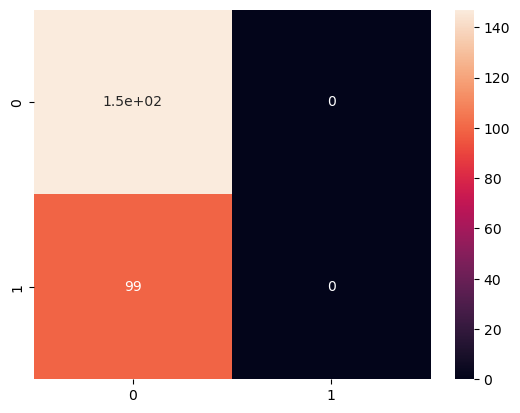

In [481]:
svm.evalMetrics(svm_model,svm_y_pred)

**Notes:**
- The model shows the prediction values with 0, but no 1, which means it fails to capture the minority class
- The confusion matrix shows that 147 values are predicted correctly, but 99 values are incorrectly predicted
- The classification report shows the accuracy is 36%, which is terrible

### Tune Hyperparameters
- Reviewing various indicators of prediction quality for the base model
- Trying Gaussian kernel, which is a good default choice and also appropriate to the complex and nonlinear relationships between features and target variable
- Utilizing forward chaining cross-validation method and grid search to identify optimal combination of multiple hyperparameters, c and gamma

In [499]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [538]:
baseModel = Pipeline([('scaler', StandardScaler()),('svm', SVC())])
baseModel.fit(X_train, y_train)
y_pred = baseModel.predict(X_test)

In [540]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5975609756097561


In [542]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       147
           1       0.00      0.00      0.00        99

    accuracy                           0.60       246
   macro avg       0.30      0.50      0.37       246
weighted avg       0.36      0.60      0.45       246



/Users/iris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/iris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/iris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [544]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[147   0]
 [ 99   0]]


In [546]:
print("\nTraining Score:", baseModel.score(X_train, y_train))


Training Score: 0.6225839267548321


In [548]:
print("\nTesting Score:", baseModel.score(X_test, y_test))


Testing Score: 0.5975609756097561


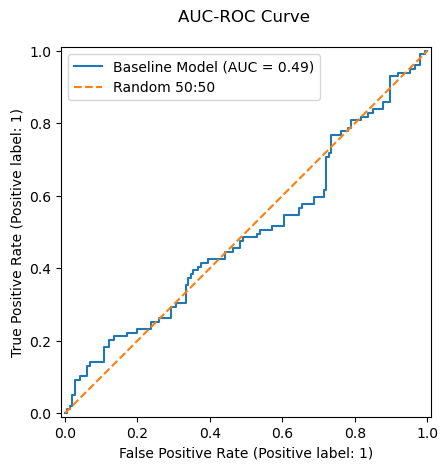

In [550]:
disp = RocCurveDisplay.from_estimator(
            baseModel, 
            X_test, 
            y_test,
            name='Baseline Model')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

In [559]:
tscv = TimeSeriesSplit(n_splits=5, gap=1)

In [656]:
baseModel = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

param_grid = {'svm__C': [0.01, 0.1, 1, 10, 100], 'svm__gamma': ['auto',1, 0.1, 0.01, 0.001], 'svm__kernel': ['rbf']} 
gs = GridSearchCV(baseModel, 
                  param_grid, 
                  scoring='f1_weighted',
                  refit=True,
                  cv=tscv, 
                  verbose=4)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END svm__C=0.01, svm__gamma=auto, svm__kernel=rbf;, score=0.364 total time=   0.0s
[CV 2/5] END svm__C=0.01, svm__gamma=auto, svm__kernel=rbf;, score=0.474 total time=   0.0s
[CV 3/5] END svm__C=0.01, svm__gamma=auto, svm__kernel=rbf;, score=0.444 total time=   0.0s
[CV 4/5] END svm__C=0.01, svm__gamma=auto, svm__kernel=rbf;, score=0.459 total time=   0.1s
[CV 5/5] END svm__C=0.01, svm__gamma=auto, svm__kernel=rbf;, score=0.459 total time=   0.0s
[CV 1/5] END svm__C=0.01, svm__gamma=1, svm__kernel=rbf;, score=0.364 total time=   0.0s
[CV 2/5] END svm__C=0.01, svm__gamma=1, svm__kernel=rbf;, score=0.474 total time=   0.0s
[CV 3/5] END svm__C=0.01, svm__gamma=1, svm__kernel=rbf;, score=0.444 total time=   0.0s
[CV 4/5] END svm__C=0.01, svm__gamma=1, svm__kernel=rbf;, score=0.459 total time=   0.1s
[CV 5/5] END svm__C=0.01, svm__gamma=1, svm__kernel=rbf;, score=0.459 total time=   0.2s
[CV 1/5] END svm__C=0.01, svm__ga

GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [0.01, 0.1, 1, 10, 100],
                         'svm__gamma': ['auto', 1, 0.1, 0.01, 0.001],
                         'svm__kernel': ['rbf']},
             scoring='f1_weighted', verbose=4)

In [658]:
gs.best_params_

{'svm__C': 10, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}

**Notes:** The grid search shows the best hyper parameters: c = 10, gamma = auto, namely 1/8
Then, using the best hyper parameters to do prediction.

In [660]:
grid_predictions = gs.predict(X_test)

<Axes: >

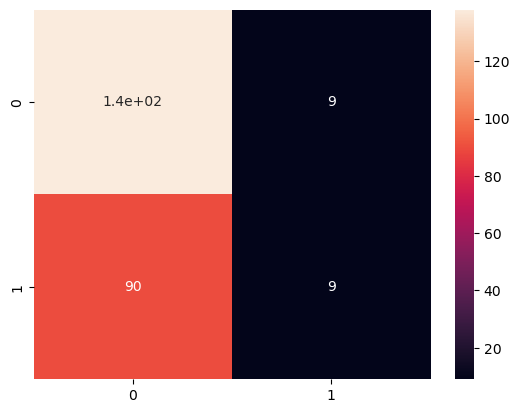

In [662]:
cm = confusion_matrix(y_test, grid_predictions)
sns.heatmap(cm, annot=True)

In [664]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, grid_predictions))


Confusion Matrix:
[[138   9]
 [ 90   9]]


In [666]:
print("\nClassification Report:")
print(classification_report(y_test, grid_predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.94      0.74       147
           1       0.50      0.09      0.15        99

    accuracy                           0.60       246
   macro avg       0.55      0.51      0.44       246
weighted avg       0.56      0.60      0.50       246



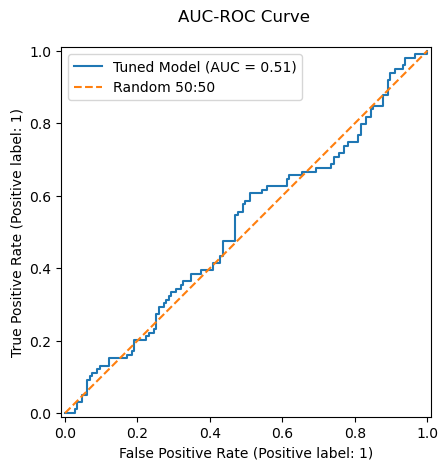

In [668]:
disp = RocCurveDisplay.from_estimator(
            gs, 
            X_test, 
            y_test,
            name='Tuned Model')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

- The indicators of the prediction quality show that accuracy is 0.56, which is much better than 0.36 from previous fit trials
- ROC curve is 0.51, slightly better than 0.49
- Actually,  I also tried ‘poly’ model with hyper parameters of c, gamma and degree, but it worked worse. So I did not keep the results

### Future Work
- Current results are not perfect. Support vector regression may be applied to do more accurate trials